# Cancer Cell Type Classification using Deep Neural Networks


In [3]:
#Import required libraries
import pandas as pd
import numpy as np
import zipfile
#import tensorflow as tf

In [4]:
#Extract zip files in the current directory
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
#Load both data sets
mainsdf = pd.read_csv('data_labels_mainData.csv')
extradf = pd.read_csv('data_labels_extraData.csv')

In [ ]:
mainsdf["cellTypeName"].value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faacac2da50>]],
      dtype=object)

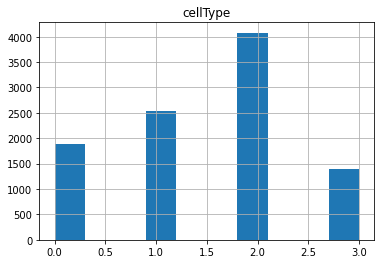

In [ ]:
import matplotlib.pyplot as plt
mainsdf.hist(column="cellType")

## Data Splits

Since we have images from patients, we use patientID to split the datasets into training, validation and test splits. A quick inspection is performed to ensure data is independent across each set

In [ ]:

#Split train, validation and test based on patient ID. 
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 40).split(mainsdf, groups=mainsdf['patientID']))

train_data = mainsdf.iloc[train_inds]
test_data = mainsdf.iloc[test_inds]

train_ind, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 40).split(train_data, groups=train_data['patientID']))

val_data  = train_data.iloc[val_inds]

train_data = train_data.iloc[train_ind]

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 6778, Val Data: 1376, Test Data: 1742


In [ ]:
#Check whether there are any data leakage while splitting
print('Train and Test Set Intersection', (pd.Index(train_data).intersection(pd.Index(test_data))).values)
print('Train and Validation Set Intersection ', (pd.Index(train_data).intersection(pd.Index(val_data))).values)
print('Validation and Test Set Intersection ', (pd.Index(val_data).intersection(pd.Index(test_data))).values)

Train and Test Set Intersection []
Train and Validation Set Intersection  []
Validation and Test Set Intersection  []


In [ ]:
print('There are {} patients in Training Set'.format(len(train_data['patientID'].unique())))
print('There are {} patients in Validation Set'.format(len(val_data['patientID'].unique())))
print('There are {} patients in Test Set'.format(len(test_data['patientID'].unique())))

There are 38 patients in Training Set
There are 10 patients in Validation Set
There are 12 patients in Test Set


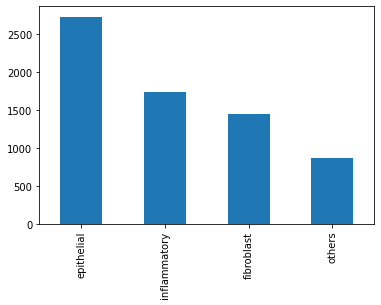

In [ ]:
train_data['cellTypeName'].value_counts().plot.bar();

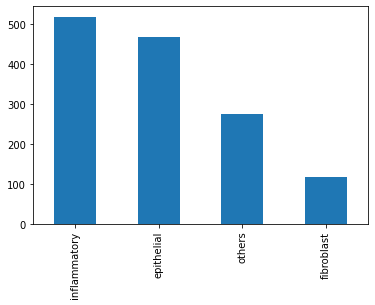

In [ ]:
val_data['cellTypeName'].value_counts().plot.bar();

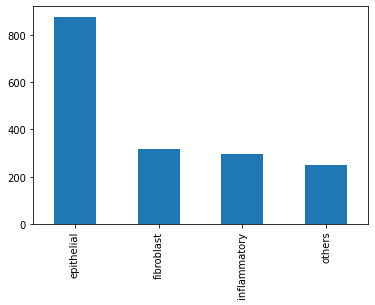

In [ ]:
test_data['cellTypeName'].value_counts().plot.bar();

Looking at each distrution, data is imbalanced across the classes and hence we decide to evaluate the performance based on macro-average f1-score. Additionally, precision, recall and confusion matrices are used to compare between model's performance.

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
#Custom function for f1-score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Custom functions for plotting confusion matrix, and calculating model results
import seaborn as sns
from sklearn.metrics import classification_report, f1_score,confusion_matrix

def plot_confusion_matrix(y_test,y_pred):

    conf_data = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(conf_data, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size

    return sns.heatmap(df_cm, cmap="Blues",annot=True,square=True,annot_kws={"size": 16},fmt="g");# font size

def model_result(X_train, X_val, model):
  y_hat_all = list()
  y_all = list()
  y_pred_all = []
  y_true_all = []
  filenames = validation_generator.filenames
  N_images = len(filenames)
  batches = 0

  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  for x,y in X_val:
          y_hat = model.predict(x, verbose=0)
          y_hat = np.argmax(y_hat, axis = 1)
          y = np.argmax(y, axis = 1)
          y_hat_all = y_hat_all + y_hat.tolist()
          y_all = y_all + y.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  for a,b in X_train:
          y_pred = model.predict(a, verbose=0)
          y_pred = np.argmax(y_pred, axis = 1)
          y_true = np.argmax(b, axis = 1)
          y_pred_all = y_pred_all + y_pred.tolist()
          y_true_all = y_true_all + y_true.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  # now you have made the predictions you can use any performance metric
  # you wish: either in sklearn or some function you have written

  print("Training F1- score: ", f1_score(y_true_all, y_pred_all,average='macro'))
  print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
  print(confusion_matrix(y_all, y_hat_all))
  print(classification_report(y_all,y_hat_all))

In [ ]:
#Base Model
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES = 4

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.5.0'

In [ ]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 6778 validated image filenames belonging to 4 classes.
Found 1376 validated image filenames belonging to 4 classes.


## Baseline MLP Model

We started with a simple neural network architecture with just one hidden layer consisting of 128 neurons. A non-linear activation relu is used on hidden layer and softmax activation for the output layers. relu is computationally efficient and softmax provides probabilities of each class labels.

In [ ]:
#Base model

model_dense_128 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation= 'softmax')
])

model_dense_128.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', f1])

In [ ]:
model_dense_128.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               280064    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 280,580
Trainable params: 280,580
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_dense_128 = model_dense_128.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


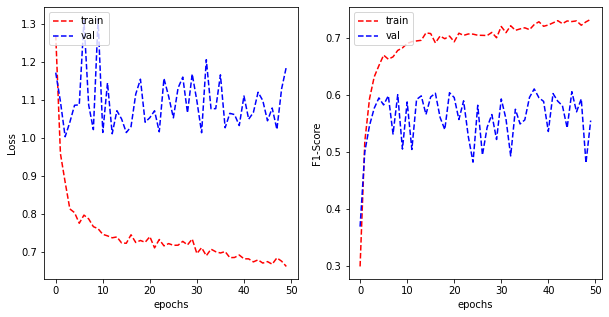

In [ ]:
plot_learning_curve(history_dense_128.history['loss'], history_dense_128.history['val_loss'], 
                    history_dense_128.history['f1'], history_dense_128.history['val_f1'], 
                    metric_name='F1-Score')

In [ ]:
model_result(train_generator,validation_generator,model_dense_128)

Training F1- score:  0.632154052843708
F1 score:  0.4435199580627636
[[ 85  10  21   0]
 [113 280 121   4]
 [ 22  35 411   0]
 [ 99 109  61   5]]
              precision    recall  f1-score   support

           0       0.27      0.73      0.39       116
           1       0.65      0.54      0.59       518
           2       0.67      0.88      0.76       468
           3       0.56      0.02      0.04       274

    accuracy                           0.57      1376
   macro avg       0.53      0.54      0.44      1376
weighted avg       0.60      0.57      0.52      1376



Looking at the resuls, the model could not perform well so we decided one more hidden layer to see how well the training score improves.

In [ ]:
HIDDEN_LAYER_DIM = 256

model_dense_256 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation= 'softmax')
])

model_dense_256.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', f1])

In [ ]:
history_dense_256 = model_dense_256.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

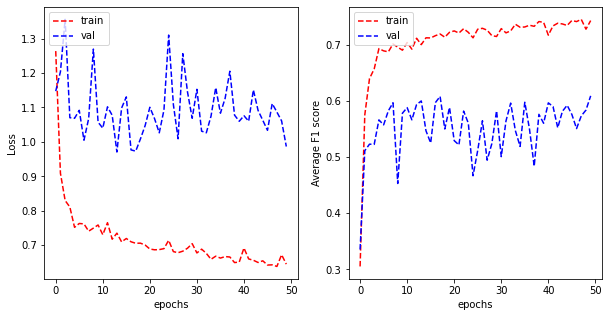

In [ ]:
plot_learning_curve(history_dense_256.history['loss'], history_dense_256.history['val_loss'], 
                    history_dense_256.history['f1'], history_dense_256.history['val_f1'], 
                    metric_name='Average F1 score')

The model performed well on traning data however, validation loss is still higher and could not performed well indicating overfitting. Therefore, we reduce the number of hidden layer and apply regularisation with lambda of 0.01 another model with dropout of 0.3

In [ ]:
# Regularization to fix overfitting

In [ ]:
reg_lambda = 0.01

HIDDEN_LAYER_DIM = 128

model_128_dense_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation= 'softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])


model_128_dense_reg.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', f1])

In [ ]:
history_128_dense_reg = model_128_dense_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

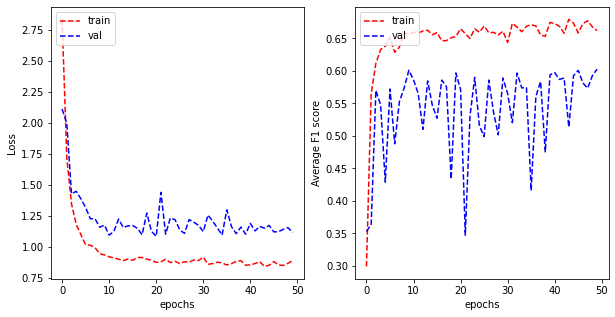

In [ ]:
plot_learning_curve(history_128_dense_reg.history['loss'], history_128_dense_reg.history['val_loss'], 
                    history_128_dense_reg.history['f1'], history_128_dense_reg.history['val_f1'], 
                    metric_name='Average F1 score')

In [ ]:

model_128_dense_dropOut = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation= 'softmax')
])

model_128_dense_dropOut.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', f1])


In [ ]:
history_128_dense_dropOut = model_128_dense_dropOut.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

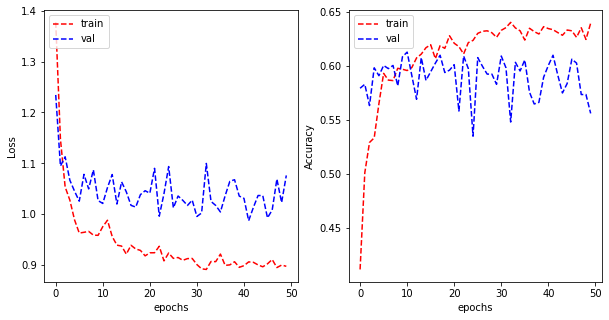

In [ ]:
plot_learning_curve(history_128_dense_dropOut.history['loss'], history_128_dense_dropOut.history['val_loss'], 
                    history_128_dense_dropOut.history['categorical_accuracy'], history_128_dense_dropOut.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_result(train_generator,validation_generator,model_128_dense_reg)

Training F1- score:  0.4297619047619048
F1 score:  0.4772000057633119
[[ 59  41  16   0]
 [ 18 420  80   0]
 [  2 102 364   0]
 [ 42 188  44   0]]
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       116
           1       0.56      0.81      0.66       518
           2       0.72      0.78      0.75       468
           3       0.00      0.00      0.00       274

    accuracy                           0.61      1376
   macro avg       0.44      0.52      0.48      1376
weighted avg       0.50      0.61      0.55      1376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results on both approaches result in underfitting so we decided to explore CNN based models. We plan to explore RCC Net and VGG net for our learning task as RCC Net was used in a similar dataset and VGG had promising results in classification tasks. 

In [ ]:
model_RCCNet_1 = tf.keras.Sequential([
    
    #RCC block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [ ]:
model_RCCNet_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_RCCNet_1 = model_RCCNet_1.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

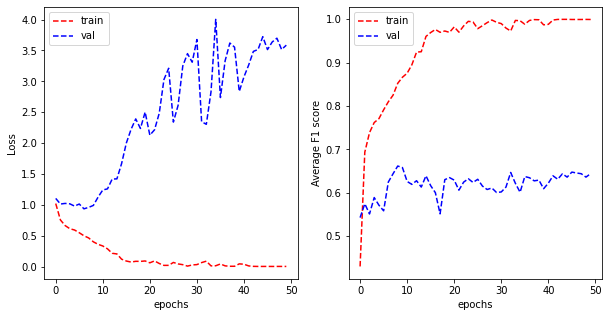

In [ ]:
plot_learning_curve(history_RCCNet_1.history['loss'], history_RCCNet_1.history['val_loss'], 
                    history_RCCNet_1.history['f1'], history_RCCNet_1.history['val_f1'], 
                    metric_name='Average F1 score')

In [ ]:
model_RCCNet_2 = tf.keras.Sequential([
    
    #RCC block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 3
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [ ]:
model_RCCNet_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)             

In [ ]:
model_RCCNet_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_RCCNet_2 = model_RCCNet_2.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

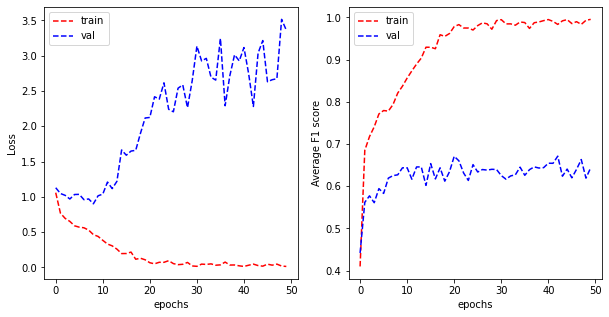

In [ ]:
plot_learning_curve(history_RCCNet_2.history['loss'], history_RCCNet_2.history['val_loss'], 
                    history_RCCNet_2.history['f1'], history_RCCNet_2.history['val_f1'], 
                    metric_name='Average F1 score')

In [ ]:
model_result(train_generator,validation_generator,model_RCCNet_2)

Training F1- score:  1.0
F1 score:  0.5804286456482112
[[ 87  12   2  15]
 [ 57 362  46  53]
 [ 35  57 360  16]
 [ 59 113  26  76]]
              precision    recall  f1-score   support

           0       0.37      0.75      0.49       116
           1       0.67      0.70      0.68       518
           2       0.83      0.77      0.80       468
           3       0.47      0.28      0.35       274

    accuracy                           0.64      1376
   macro avg       0.58      0.62      0.58      1376
weighted avg       0.66      0.64      0.64      1376



In [ ]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_aug = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=45, width_shift_range=0.2,
                                   height_shift_range=0.2,horizontal_flip=True,vertical_flip = True)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/drive/MyDrive/Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 6778 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
model_RCCNet_3 = tf.keras.Sequential([
    #RCC block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [ ]:
model_RCCNet_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_RCCNet_3 = model_RCCNet_3.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=50, verbose=1)

In [ ]:
model_RCCNet_4.save('model_RCCNet_4')

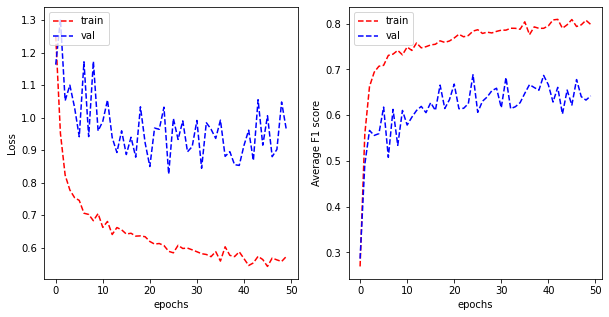

In [ ]:
plot_learning_curve(history_RCCNet_3.history['loss'], history_RCCNet_3.history['val_loss'], 
                    history_RCCNet_3.history['f1'], history_RCCNet_3.history['val_f1'], 
                    metric_name='Average F1 score')

In [ ]:
model_result(train_generator_aug,validation_generator,model_RCCNet_3)

Training F1- score:  0.7508912037037037
F1 score:  0.5679592277150154
[[ 96   9  10   1]
 [ 81 373  39  25]
 [ 45  43 375   5]
 [ 68 127  28  51]]
              precision    recall  f1-score   support

           0       0.33      0.83      0.47       116
           1       0.68      0.72      0.70       518
           2       0.83      0.80      0.82       468
           3       0.62      0.19      0.29       274

    accuracy                           0.65      1376
   macro avg       0.61      0.63      0.57      1376
weighted avg       0.69      0.65      0.64      1376



In [ ]:
reg_lambda = 0.01
model_RCCNet_4 = tf.keras.Sequential([
          
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 3
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [ ]:
model_RCCNet_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_RCCNet_4 = model_RCCNet_4.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=50, verbose=1)

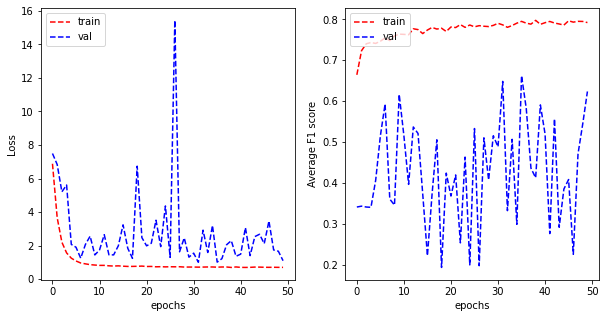

In [ ]:
plot_learning_curve(history_RCCNet_4.history['loss'], history_RCCNet_4.history['val_loss'], 
                    history_RCCNet_4.history['f1'], history_RCCNet_4.history['val_f1'], 
                    metric_name='Average F1 score')

In [ ]:
model_result(train_generator_aug,validation_generator,model_RCCNet_4)

Training F1- score:  0.6794649262143881
F1 score:  0.5726713774621482
[[ 99  12   3   2]
 [ 96 358  17  47]
 [ 57  70 334   7]
 [ 61 118  20  75]]
              precision    recall  f1-score   support

           0       0.32      0.85      0.46       116
           1       0.64      0.69      0.67       518
           2       0.89      0.71      0.79       468
           3       0.57      0.27      0.37       274

    accuracy                           0.63      1376
   macro avg       0.61      0.63      0.57      1376
weighted avg       0.69      0.63      0.63      1376



We tried three different approaches adopting RCC Net architecture however, the results couldn't be improved. First, our class labels were imbalanced, second we had less number of traning samples where this particular model could not perform better. Therefore, we decide to move on to applying VGG net model and see if it improves the results. We stated with 2 VGG blocks with 64 and 128 filters and used 2 fully connected hidden layers with 256 neurons each.

In [ ]:
model_VGG16_1 = tf.keras.Sequential([
    #VGG block 1  
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model_VGG16_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_VGG16_1 = model_VGG16_1.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

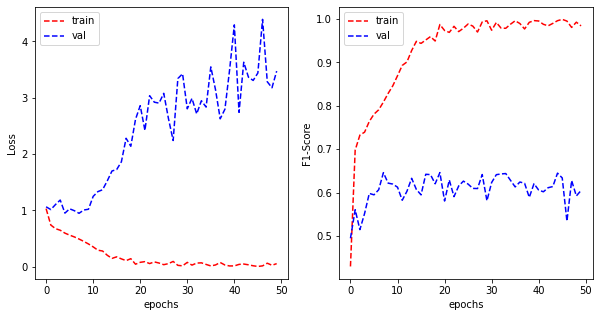

In [ ]:
plot_learning_curve(history_VGG16_1.history['loss'], history_VGG16_1.history['val_loss'], 
                    history_VGG16_1.history['f1'], history_VGG16_1.history['val_f1'], 
                    metric_name='F1-Score')

In [ ]:
model_result(train_generator,validation_generator,model_VGG16_1)

Training F1- score:  1.0
F1 score:  0.5361704216655097
[[ 81  10  21   4]
 [ 83 306  75  54]
 [ 32  41 377  18]
 [ 70 104  33  67]]
              precision    recall  f1-score   support

           0       0.30      0.70      0.42       116
           1       0.66      0.59      0.63       518
           2       0.75      0.81      0.77       468
           3       0.47      0.24      0.32       274

    accuracy                           0.60      1376
   macro avg       0.55      0.58      0.54      1376
weighted avg       0.62      0.60      0.60      1376



The model was highly overfitted so we decided to reduce the number of neurons and add dropout of 0.2 on the second hidden layer.

In [ ]:
model_VGG16_2 = tf.keras.Sequential([
    #VGG block 1  
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model_VGG16_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_VGG16_2 = model_VGG16_2.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

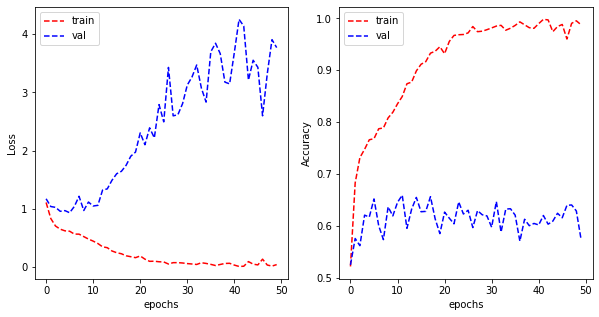

In [ ]:
plot_learning_curve(history_VGG16_2.history['loss'], history_VGG16_2.history['val_loss'], 
                    history_VGG16_2.history['categorical_accuracy'], history_VGG16_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

We obseved that there wasn't any significant change so we decided to add weight regularisation, increase one hideen layer neuron to 256. 

In [ ]:
reg_lambda = 0.00001
model_VGG16_3 = tf.keras.Sequential([
    #VGG block 1  
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model_VGG16_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_VGG16_3 = model_VGG16_3.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

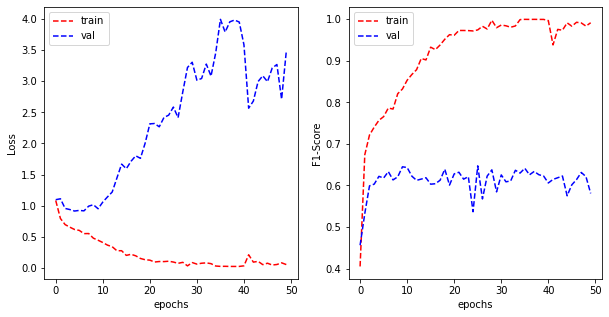

In [ ]:
plot_learning_curve(history_VGG16_3.history['loss'], history_VGG16_3.history['val_loss'], 
                    history_VGG16_3.history['f1'], history_VGG16_3.history['val_f1'], 
                    metric_name='F1-Score')

# Data Augmentation

Since, drop out and regularisation which was tweaked iteratively could not generalise well, we decided to augemnt the data to increase the nature of data and avoid overfitting.

In [ ]:
model_VGG16_4 = tf.keras.Sequential([
    
    #VGG block 1  
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model_VGG16_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

In [ ]:
history_VGG16_4 = model_VGG16_4.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=50, verbose=1)

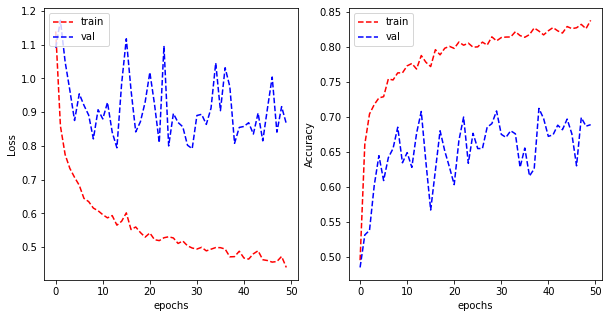

In [ ]:
plot_learning_curve(history_VGG16_4.history['loss'], history_VGG16_4.history['val_loss'], 
                    history_VGG16_4.history['categorical_accuracy'], history_VGG16_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_result(train_generator_aug,validation_generator,model_VGG16_4)

Training F1- score:  0.703790945896209
F1 score:  0.6270558992563598
[[ 89  18   8   1]
 [ 25 413  17  63]
 [ 30  62 364  12]
 [ 53 115  24  82]]
              precision    recall  f1-score   support

           0       0.45      0.77      0.57       116
           1       0.68      0.80      0.73       518
           2       0.88      0.78      0.83       468
           3       0.52      0.30      0.38       274

    accuracy                           0.69      1376
   macro avg       0.63      0.66      0.63      1376
weighted avg       0.70      0.69      0.68      1376



Observing the results, the model was able to generalise well as the difference between training and validation score was comparatively less. The validation loss were minimised to some level. Therefore, we decided to use this model to test on the unseen data. 

In [ ]:
#Apply VGG net 4 on test data 

test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=test_batch_size,
        class_mode='categorical')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Found 1742 validated image filenames belonging to 4 classes.


In [ ]:
model_VGG16_4.evaluate(test_generator)

1742/1742 [==============================] - 419s 241ms/step - loss: 0.6476 - categorical_accuracy: 0.7543 - f1: 0.7302


[0.6475533246994019, 0.7543054223060608, 0.7301951050758362]

In [ ]:
y_hat_all = []
y_all = []
batches = 0
N_images = len(test_generator.filenames)
for x,y in test_generator:
    y_hat = model_VGG16_4.predict(x, verbose=0)
    y_hat = np.argmax(y_hat, axis = 1)
    y = np.argmax(y, axis = 1)
    y_hat_all = y_hat_all + y_hat.tolist()
    y_all = y_all + y.tolist()

    batches += 1
    if batches >= N_images / test_batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

Test F1 score:  0.6948269272104305


,precision,recall,f1-score,support
0,0.621170,0.699060,0.657817,319.000000
1,0.679310,0.670068,0.674658,294.000000
2,0.886659,0.854380,0.870220,879.000000
3,0.581301,0.572000,0.576613,250.000000
accuracy,0.754305,0.754305,0.754305,0.754305
macro avg,0.692110,0.698877,0.694827,1742.000000
weighted avg,0.759224,0.754305,0.756182,1742.000000


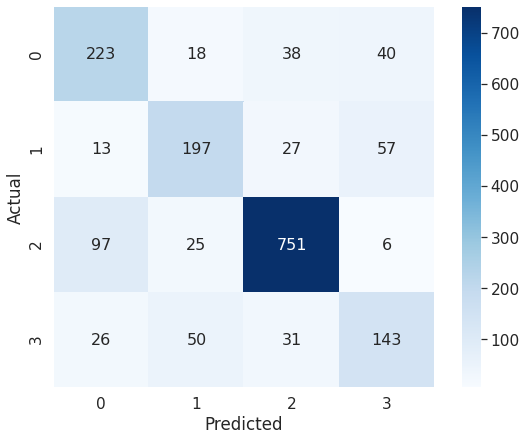

In [ ]:
print("Test F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
plot_confusion_matrix(y_all,y_hat_all)
pd.DataFrame(classification_report(y_all,y_hat_all,output_dict = True)).transpose()

Out model_VGG_4 achieved 0.69 macro average f1 score on the test set. It is by far the best results on predicting each class lables. In addition, the precision and recall of minority class label was moderate. Further evidence from confusion matrix suggests this model performed well on overall. Now, we intend to use this model and generate lables for the data available from "extraData.csv". These generated labels are then combined with the traning set to see if it could improve the results on the test set.

In [ ]:
extra_df_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

extra_batch_size = 1

extra_generator = extra_df_gen.flow_from_dataframe(
        dataframe=extradf,
        directory='patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=extra_batch_size,
        class_mode=None)

Found 10384 validated image filenames.


In [ ]:
predictions = model_VGG16_4.predict_generator(extra_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
preds = predictions.argmax(axis = 1)

In [ ]:
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_label = np.vectorize(idx_to_cls.get)(preds)
extradf['cellType'] = preds_label

array(['2', '1', '2', ..., '1', '2', '1'], dtype='<U1')

In [ ]:
combined_train_data = pd.concat([train_data,extradf])

In [ ]:
combined_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

combined_train_generator = combined_train_datagen.flow_from_dataframe(
        dataframe=combined_train_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 17162 validated image filenames belonging to 4 classes.


In [ ]:
history_VGG16_final = model_VGG16_4.fit_generator(combined_train_generator, validation_data = validation_generator, epochs=50, verbose=1)

In [ ]:
plot_learning_curve(history_VGG16_final.history['loss'], history_VGG16_final.history['val_loss'], 
                    history_VGG16_final.history['categorical_accuracy'], history_VGG16_final.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
y_hat_all = []
y_all = []
batches = 0
N_images = len(test_generator.filenames)
for x,y in test_generator:
    y_hat = model_VGG16_4.predict(x, verbose=0)
    y_hat = np.argmax(y_hat, axis = 1)
    y = np.argmax(y, axis = 1)
    y_hat_all = y_hat_all + y_hat.tolist()
    y_all = y_all + y.tolist()

    batches += 1
    if batches >= N_images / test_batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
print("Final Test F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
plot_confusion_matrix(y_all,y_hat_all)
pd.DataFrame(classification_report(y_all,y_hat_all,output_dict = True)).transpose()